# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

The following notebook demonstrates the implementation of the best trial obtained from Optuna for Experiment 1. In this experiment, batch size, number of epochs, and learning rate were fixed, while other hyperparameters were optimized using Optuna.

### Importing Necessary Libraries


In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
import os
from tensorflow.keras.models import load_model
import json
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score


import optuna
%matplotlib inline

c:\Users\siddi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Matplotlib Settings

In [3]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

### 1. Preprocessing - Denoising the signal
This function denoise uses wavelet transform to remove noise from the input signal data. It applies a symmetric 4 (sym4) wavelet and performs a multi-level discrete wavelet decomposition to break the signal into approximation and detail coefficients. The function then thresholds the detail coefficients to filter out noise based on a predefined threshold. Finally, it reconstructs the signal by applying the inverse wavelet transform, returning a cleaner version of the input data.

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


### 2. Preprocessing – Reading Raw ECG Signals for 48 contiguous ECG excerpts

| **Label** | **Description**                                                                                                                                           |
|-----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **N**     | Normal heartbeat or cardiac complex. The electrical activity of the heart is within the normal range, with no abnormalities or irregularities in the heart rhythm. |
| **L**     | Left bundle branch block. An abnormality in the electrical conduction system where signals do not travel normally through the left bundle branch, affecting ventricular contractions. |
| **R**     | Right bundle branch block. An abnormality in the electrical conduction system involving the right bundle branch, similar to left bundle branch block.      |
| **A**     | Atrial premature beat. An early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.              |
| **V**     | Ventricular premature beat. An early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.     |


In [5]:
path = "C:\\Users\\siddi\\OneDrive\\Master's data\\Thesis\\mitdatabase"
#path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [6]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [7]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        #records.append(path + filename + file_extension)
        records.append(os.path.join(path, filename + file_extension))

    # *.txt
    else:
        #annotations.append(path + filename + file_extension)
        annotations.append(os.path.join(path, filename + file_extension))

### 3. Preprocessing - Segmentation into windows of 2000 sample points

<>:14: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:54: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:54: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
C:\Users\siddi\AppData\Local\Temp\ipykernel_20156\3542894224.py:14: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if r is 1:
C:\Users\siddi\AppData\Local\Temp\ipykernel_20156\3542894224.py:22: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if r is 1:
C:\Users\siddi\AppData\Local\Temp\ipykernel_20156\3542894224.py:30: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if r is 1:
C:\Users\siddi\AppData\Local\Temp\ipykernel_20156\35

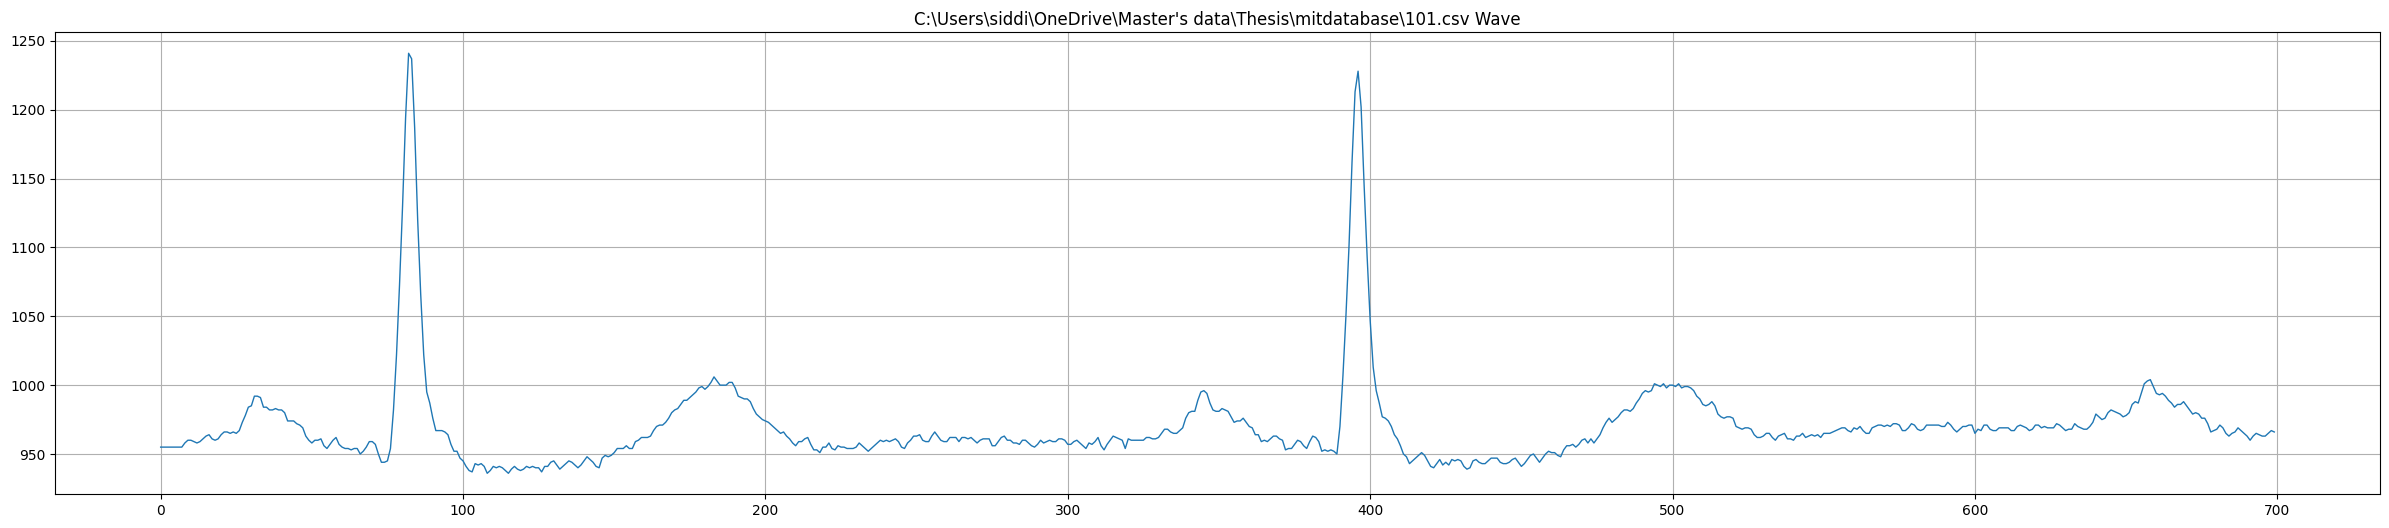

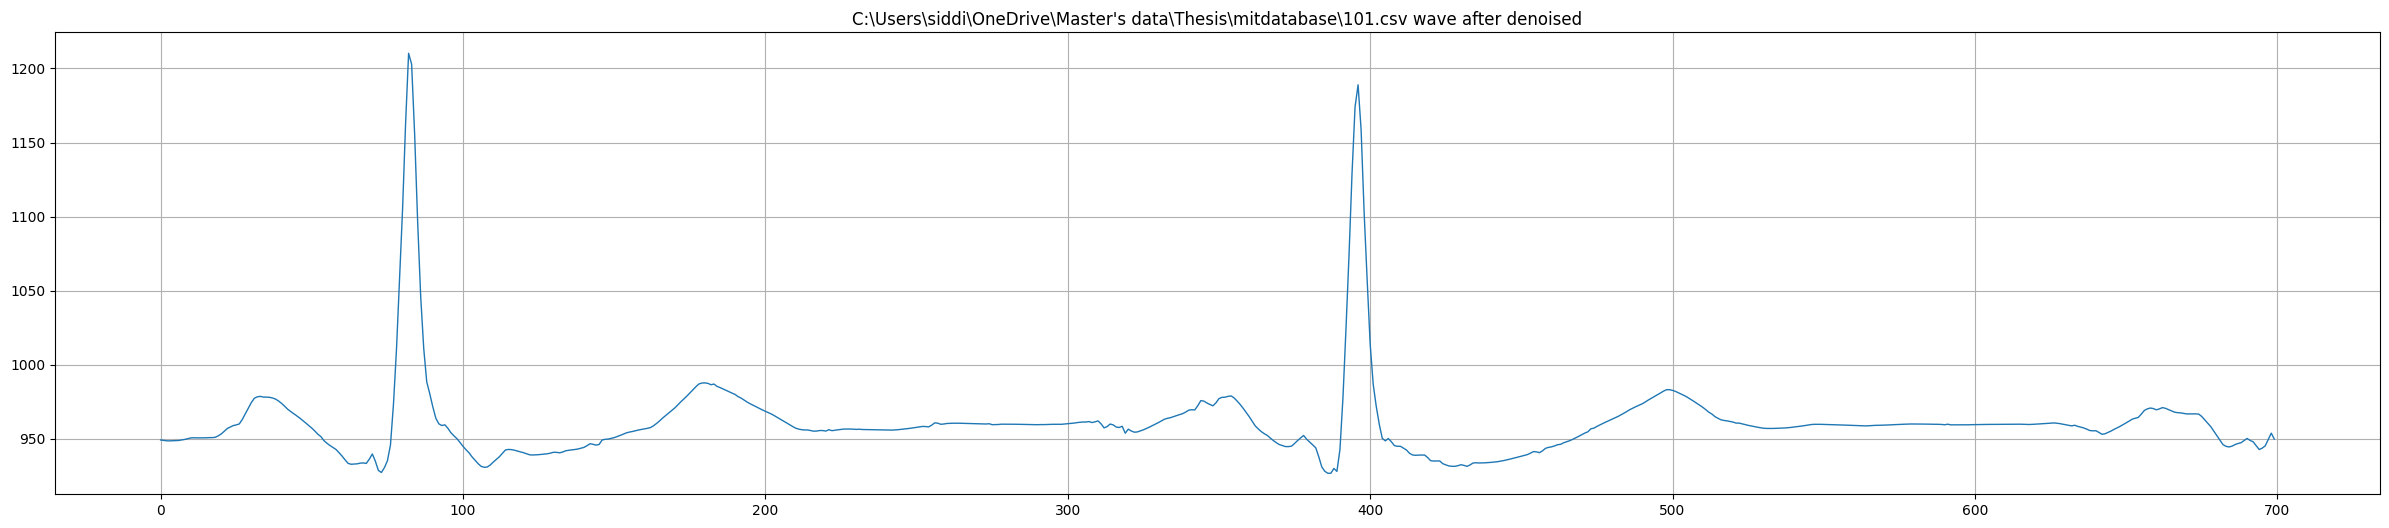

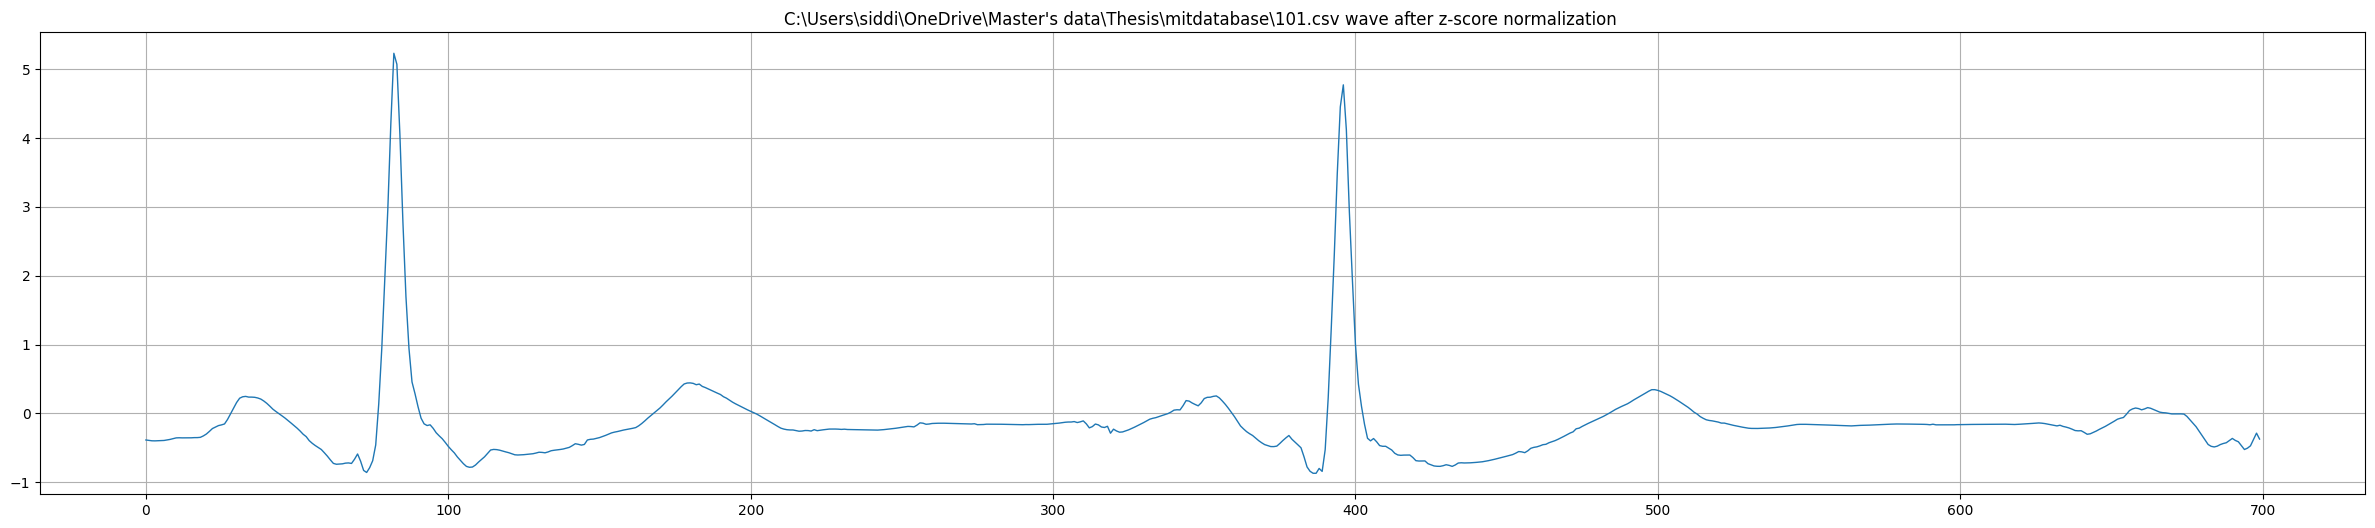

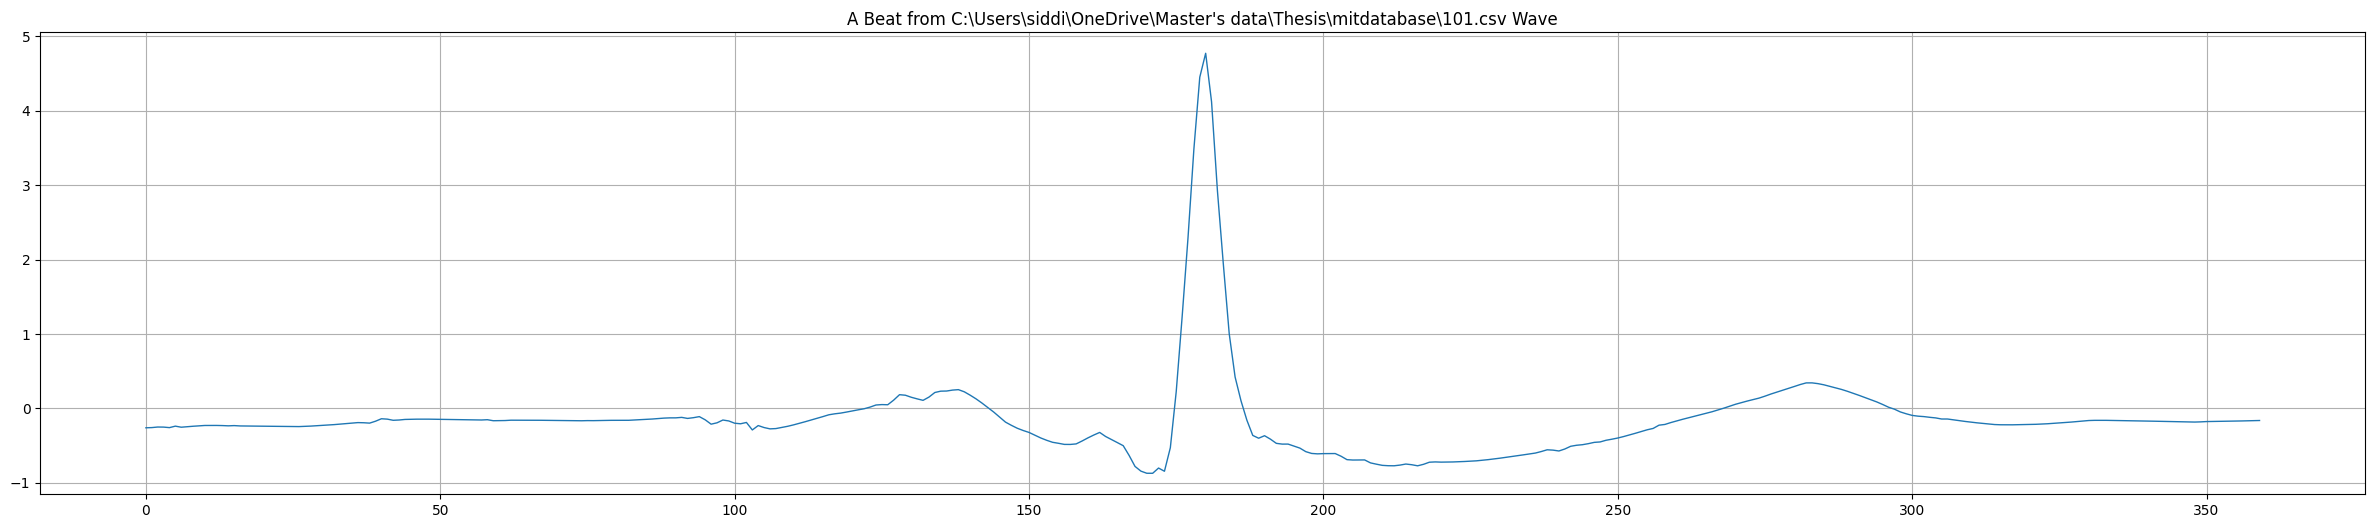

(100012, 360) (100012,)


In [8]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [9]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


### 4. Preprocessing - Balancing the classes with each class having 3000 segments

360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


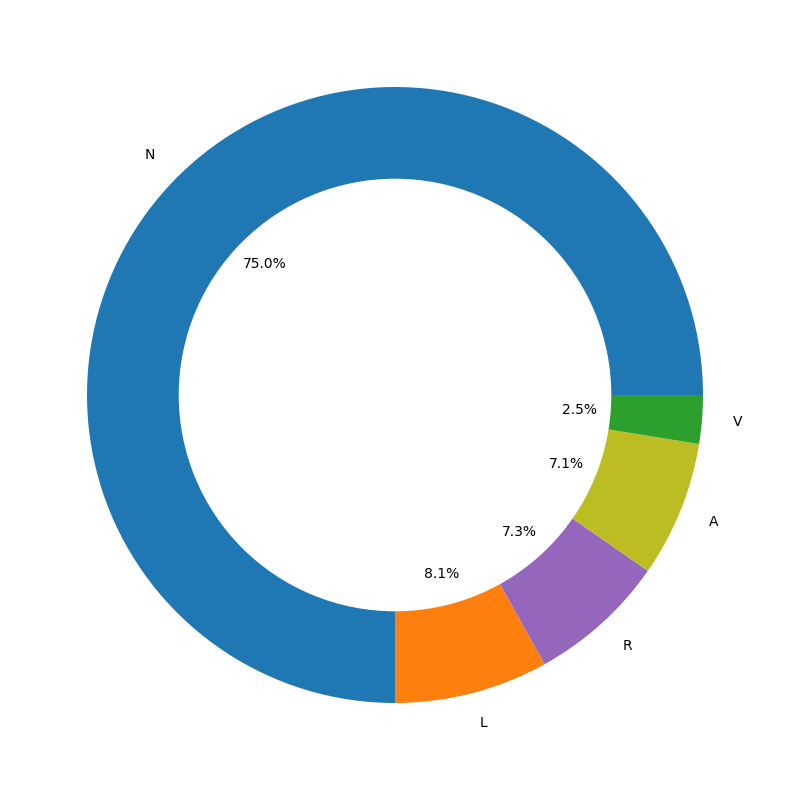

In [10]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [11]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=3000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=3000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=3000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=3000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=3000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    3000
1.0    3000
2.0    3000
3.0    3000
4.0    3000
Name: count, dtype: int64


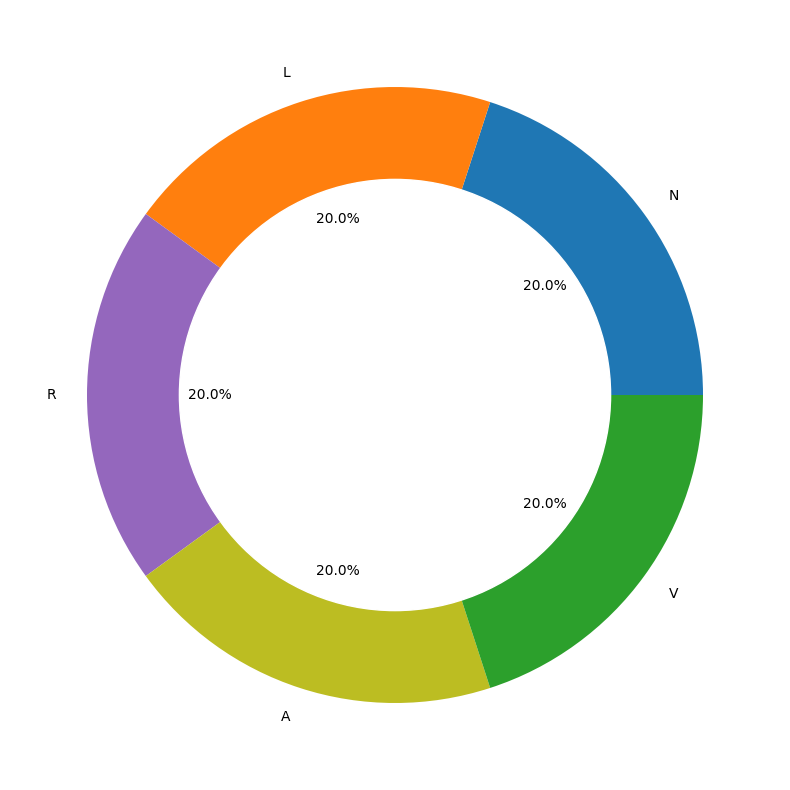

In [12]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### 5. Performing Train-Test Split before Training the model

In [13]:
# Split the original dataset into train and test sets
train, test = train_test_split(X_train_df, test_size=0.20, random_state=42)

# # Further split the training set into train and validation sets
# train, val = train_test_split(train, test_size=0.25, random_state=42)  # 25% of the training set

In [14]:
# Prepare the target and features for training, validation, and test sets
target_train = train[train.shape[1]-1]
# target_val = val[val.shape[1]-1]
target_test = test[test.shape[1]-1]

train_y = to_categorical(target_train)
# val_y = to_categorical(target_val)
test_y = to_categorical(target_test)

In [15]:
train_x = train.iloc[:, :train.shape[1]-1].values
# val_x = val.iloc[:, :val.shape[1]-1].values
test_x = test.iloc[:, :test.shape[1]-1].values

train_x = train_x.reshape(len(train_x), train_x.shape[1], 1)
# val_x = val_x.reshape(len(val_x), val_x.shape[1], 1)
test_x = test_x.reshape(len(test_x), test_x.shape[1], 1)

In [16]:
print("Training set:", train_x.shape, train_y.shape)
# print("Validation set:", val_x.shape, val_y.shape)
print("Test set:", test_x.shape, test_y.shape)

Training set: (12000, 360, 1) (12000, 5)
Test set: (3000, 360, 1) (3000, 5)


### 6. Building the Model Architecture


In [17]:
# Best trial obtained from optuna:
# Value:  0.9386666417121887
#   Params: 
#     num_layers: 2
#     num_filters_0: 80
#     num_filters_1: 64
#     kernel_size_0: 5
#     kernel_size_1: 7
#     dropout_rate: 0.3200580062760364
#     batch_size: 96
#     learn_rate: 0.0011611420918167382
#     num_epochs: 30


#### Description of the model and the parameters for each layer

In [18]:
# Instanciate an empty model
model = Sequential()
model.add(Conv1D(filters=80, kernel_size=5, padding='same', activation='relu',input_shape=(360, 1)))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.3200580062760364))
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Softmax())
model.summary()

c:\Users\siddi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 360, 80)        │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 179, 80)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 179, 64)        │        35,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 89, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5696)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5696)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 35)             │       199,395 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,959 (921.71 KB)

 Trainable params: 235,959 (921.71 KB)

 Non-trainable params: 0 (0.00 B)

### 7. Performing K-Fold Cross validation (K=5)

In [19]:
# Define K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
# Convert your data into NumPy arrays (if not already)
X = np.array(train_x)  # Assuming X_train_df contains features
y = np.array(train_y)  # Assuming y_train_df contains labels

In [21]:
# Directory to save models
save_dir = "kfold_models"
os.makedirs(save_dir, exist_ok=True)

In [22]:
fold = 1
# Loop through each fold
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Build and compile your model here
    model = Sequential()
    model.add(Conv1D(filters=80, kernel_size=5, padding='same', activation='relu',input_shape=(360, 1)))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dropout(0.3200580062760364))
    model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Softmax())

    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.0011611420918167382), metrics=['accuracy'])
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=96, epochs=30,
        verbose=1,
        validation_data=(X_val, y_val)
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Save training history
    history_path = os.path.join(save_dir, f"history_fold_{fold}.json")
    with open(history_path, "w") as f:
        json.dump(history.history, f)
        
    print(f"Training history for fold {fold} saved at: {history_path}")

    # Saving Model
    model_path = os.path.join(save_dir, f"model_fold_{fold}.h5")
    model.save(model_path)
    print(f"Model for fold {fold} saved at: {model_path}")
    
    fold += 1
    print(f"="*80)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.6973 - loss: 0.8532 - val_accuracy: 0.8988 - val_loss: 0.3423
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9128 - loss: 0.2988 - val_accuracy: 0.9171 - val_loss: 0.2963
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9263 - loss: 0.2497 - val_accuracy: 0.9279 - val_loss: 0.2437
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9313 - loss: 0.2208 - val_accuracy: 0.9342 - val_loss: 0.2473
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9435 - loss: 0.1869 - val_accuracy: 0.9354 - val_loss: 0.2440
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9446 - loss: 0.1849 - val_accuracy: 0.9392 - val_loss: 0.2279
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9455 - loss: 0.1838 - val_accuracy: 0.9388 - val_loss: 0.2266
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9530 - loss: 0.1651 - val_acc

Model for fold 1 saved at: kfold_models\model_fold_1.h5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.6932 - loss: 0.8685 - val_accuracy: 0.8904 - val_loss: 0.4121
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9044 - loss: 0.3403 - val_accuracy: 0.9200 - val_loss: 0.2702
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9248 - loss: 0.2364 - val_accuracy: 0.9296 - val_loss: 0.2314
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9331 - loss: 0.2171 - val_accuracy: 0.9417 - val_loss: 0.2106
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9426 - loss: 0.1992 - val_accuracy: 0.9337 - val_loss: 0.2197
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9465 - loss: 0.1825 - val_accuracy: 0.9438 - val_loss: 0.2006
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9545 - loss: 0.1619 - val_accuracy: 0.9504 - val_loss: 0.1951
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 

Validation Loss: 0.15363602340221405, Validation Accuracy: 0.9624999761581421
Training history for fold 2 saved at: kfold_models\history_fold_2.json
Model for fold 2 saved at: kfold_models\model_fold_2.h5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6954 - loss: 0.8405 - val_accuracy: 0.9050 - val_loss: 0.3250
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9072 - loss: 0.3158 - val_accuracy: 0.9275 - val_loss: 0.2477
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9164 - loss: 0.2626 - val_accuracy: 0.9413 - val_loss: 0.2128
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9282 - loss: 0.2272 - val_accuracy: 0.9408 - val_loss: 0.2093
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9364 - loss: 0.2089 - val_accuracy: 0.9425 - val_loss: 0.2019
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9456 - loss: 0.1857 - val_accuracy: 0.9500 - val_loss: 0.1758
Epoch 7/30
100/100 ━

Validation Loss: 0.13700896501541138, Validation Accuracy: 0.9704166650772095
Training history for fold 3 saved at: kfold_models\history_fold_3.json
Model for fold 3 saved at: kfold_models\model_fold_3.h5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6842 - loss: 0.8591 - val_accuracy: 0.9008 - val_loss: 0.3288
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9042 - loss: 0.3081 - val_accuracy: 0.9212 - val_loss: 0.2657
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9196 - loss: 0.2536 - val_accuracy: 0.9371 - val_loss: 0.2295
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9346 - loss: 0.2100 - val_accuracy: 0.9283 - val_loss: 0.2360
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9287 - loss: 0.2236 - val_accuracy: 0.9379 - val_loss: 0.2067
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9421 - loss: 0.1885 - val_accuracy: 0.9450 - val_loss: 0.1974
Epoch 7/30
100/100 ━

Validation Loss: 0.15137599408626556, Validation Accuracy: 0.9599999785423279
Training history for fold 4 saved at: kfold_models\history_fold_4.json
Model for fold 4 saved at: kfold_models\model_fold_4.h5
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6810 - loss: 0.8874 - val_accuracy: 0.9100 - val_loss: 0.3217
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9012 - loss: 0.3351 - val_accuracy: 0.9321 - val_loss: 0.2291
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9215 - loss: 0.2561 - val_accuracy: 0.9342 - val_loss: 0.2145
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9302 - loss: 0.2348 - val_accuracy: 0.9517 - val_loss: 0.1775
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9364 - loss: 0.2091 - val_accuracy: 0.9454 - val_loss: 0.1681
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9428 - loss: 0.2030 - val_accuracy: 0.9471 - val_loss: 0.1774
Epoch 7/30
100/100 ━

Validation Loss: 0.12452073395252228, Validation Accuracy: 0.9691666960716248
Training history for fold 5 saved at: kfold_models\history_fold_5.json
Model for fold 5 saved at: kfold_models\model_fold_5.h5


In [23]:
# Directory where history JSON files are stored
history_dir = "kfold_models"

# Initialize lists to store metrics for each fold
results = {
    "Fold": [],
    "Train Accuracy": [],
    "Train Loss": [],
    "Validation Accuracy": [],
    "Validation Loss": []
}

# Loop through the JSON files for each fold
for fold in range(1, 6):  # Assuming 5 folds
    history_path = os.path.join(history_dir, f"history_fold_{fold}.json")
    
    # Load the history file
    with open(history_path, "r") as f:
        history = json.load(f)
    
    # Extract the final metrics from the history
    train_loss = history["loss"][-1]
    train_acc = history["accuracy"][-1]
    val_loss = history["val_loss"][-1]
    val_acc = history["val_accuracy"][-1]
    
    # Append the results for the current fold
    results["Fold"].append(fold)
    results["Train Accuracy"].append(train_acc)
    results["Train Loss"].append(train_loss)
    results["Validation Accuracy"].append(val_acc)
    results["Validation Loss"].append(val_loss)

#### Summary of KFolds

In [24]:
# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

In [25]:
results_df

,Fold,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,1,0.978333,0.090269,0.962083,0.178540
1,2,0.973021,0.103337,0.962500,0.153636
2,3,0.973646,0.107646,0.970417,0.137009
3,4,0.973958,0.099089,0.960000,0.151376
4,5,0.970833,0.109188,0.969167,0.124521


### 8. Saving KFold models and their training history

In [26]:
!zip -r output_folder.zip kfold_models

'zip' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
import shutil

# Create a ZIP file for the folder "kfold_models"
shutil.make_archive("output_folder", "zip", "kfold_models")

print("ZIP file created successfully: output_folder.zip")


ZIP file created successfully: output_folder.zip


In [27]:
!ls /kaggle/working/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
!dir /kaggle/working/


Invalid switch - "kaggle".


### 9. Finding the performance on test Data

**Plotting the loss convergence**

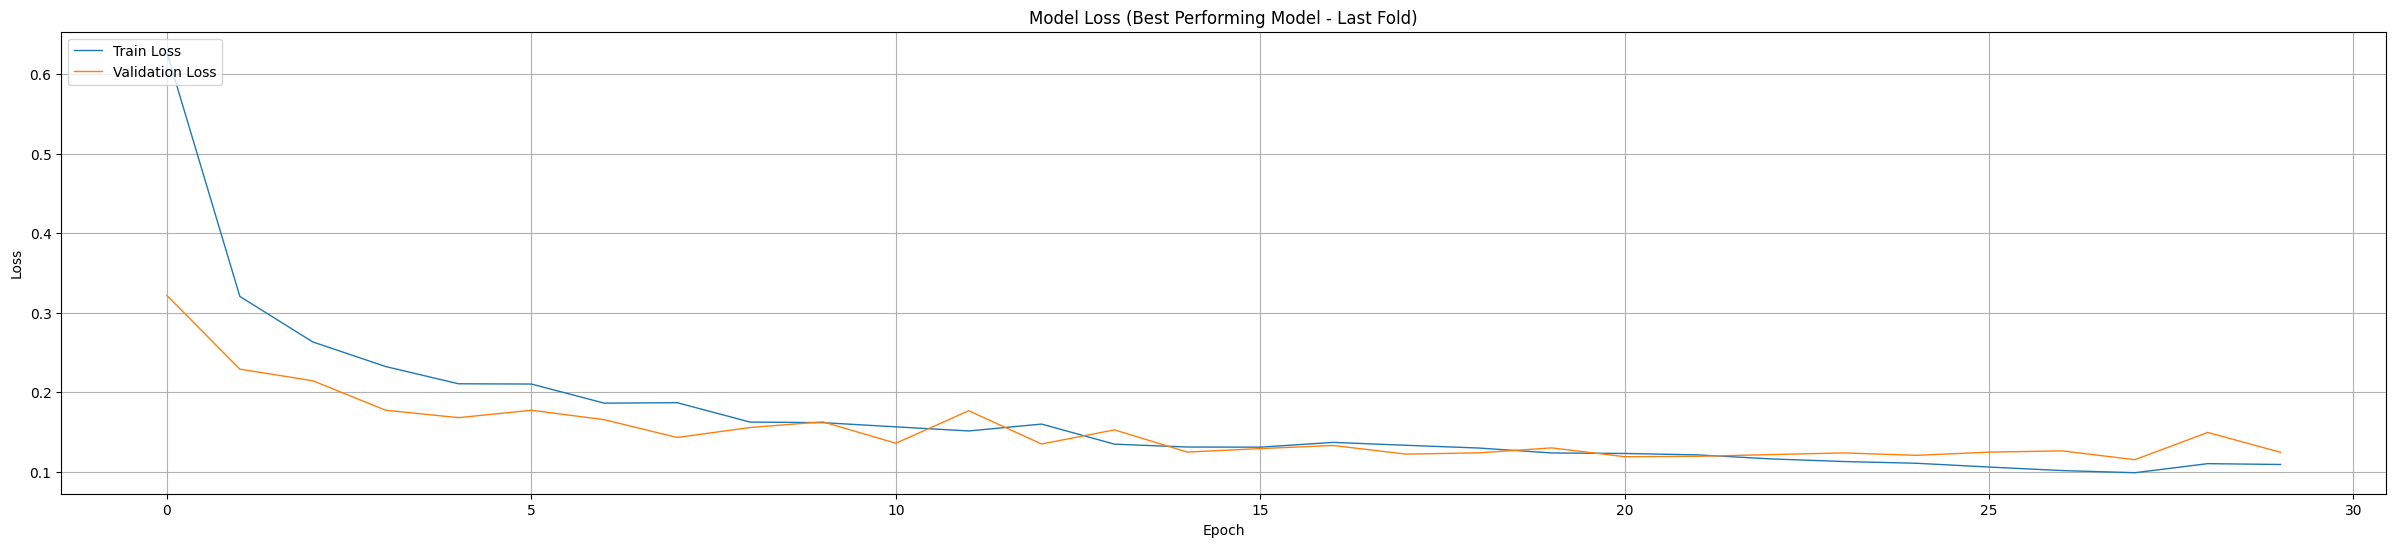

In [36]:
# Path to the history file for the last fold (best-performing model)
#history_path = "/kaggle/input/output-folder-kfold/kfold_models_all_randomized/history_fold_5.json"  # Update this with the correct file name if needed
history_path = "C:\\Users\\siddi\\OneDrive\\Master's data\\Thesis\\kfold_models\\history_fold_5.json"
#"C:\Users\siddi\OneDrive\Master's data\Thesis\kfold_models"
#path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'


# Load the history file
with open(history_path, "r") as f:
    best_model_history = json.load(f)

# Plot loss
plt.plot(best_model_history['loss'], label='Train Loss')
plt.plot(best_model_history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Best Performing Model - Last Fold)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

**Plotting accuracy**

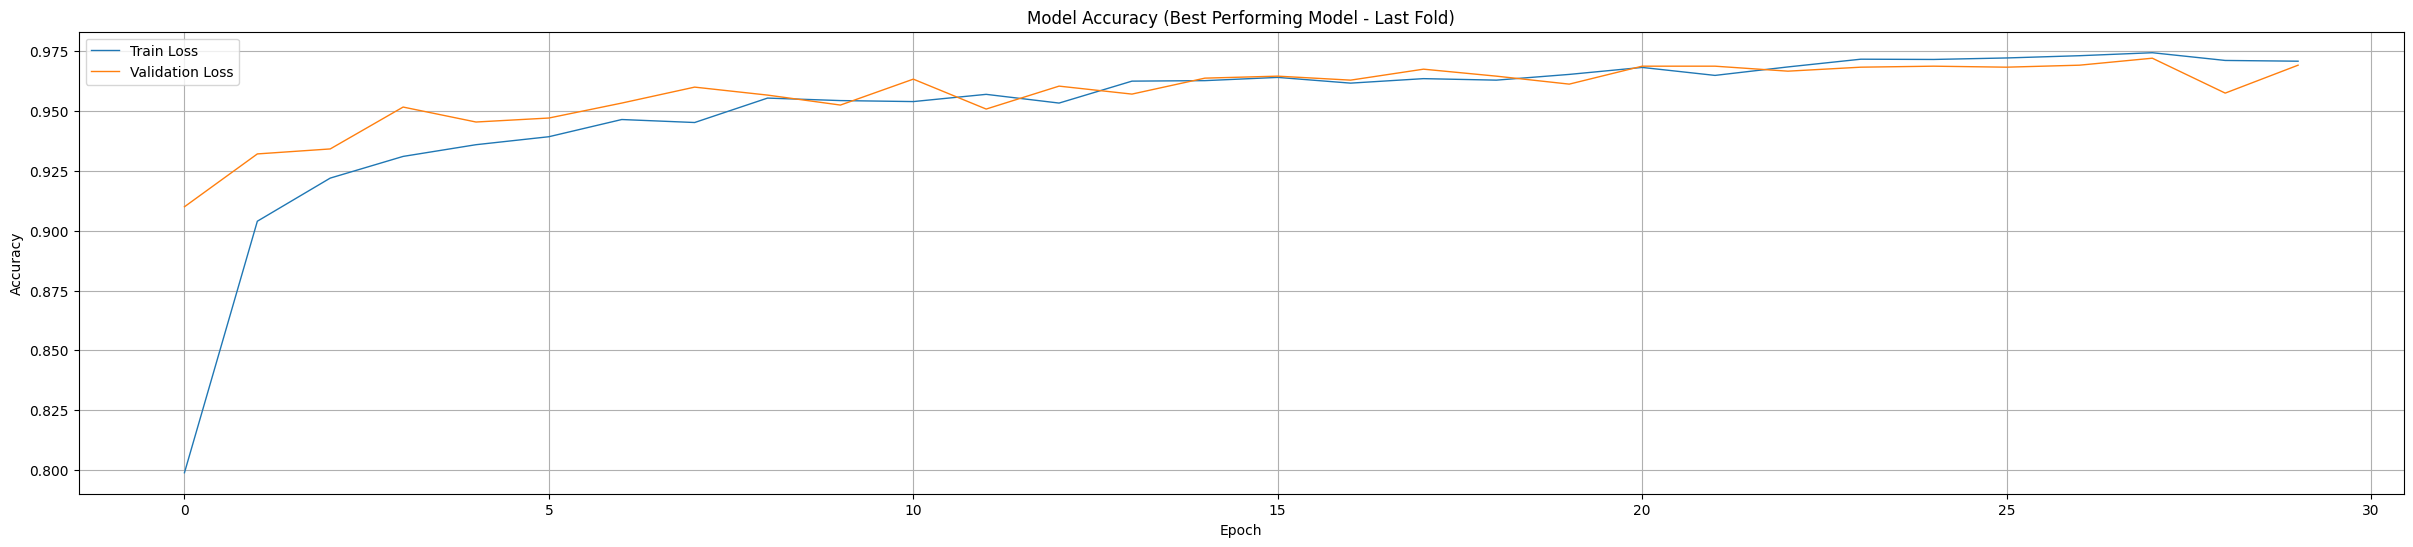

In [37]:
# Plot loss
plt.plot(best_model_history['accuracy'], label='Train Loss')
plt.plot(best_model_history['val_accuracy'], label='Validation Loss')
plt.title('Model Accuracy (Best Performing Model - Last Fold)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Finding the performance on test Data

In [39]:
# List to store true labels and predictions from all folds
all_true_labels = []
all_pred_probs = []
all_pred_classes = []

# Number of folds
num_folds = 5  # Adjust as per your k-fold cross-validation

# Iterate through each fold's model
for fold in range(1, num_folds + 1):
    print(f"Evaluating Fold {fold}...")
    
    # Load the model for the current fold
    model_path =f"C:\\Users\\siddi\\OneDrive\\Master's data\\Thesis\\kfold_models\\model_fold_{fold}.h5"
    #model_path = f"/kaggle/input/output-folder-kfold/kfold_models_all_randomized/model_fold_{fold}.h5"  # Update path as per your folder structure
    model = load_model(model_path)
    
    # Predict probabilities for the test data of the current fold
    test_predictions = model.predict(test_x)  # Replace with fold-specific test_x
    predicted_classes = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels
    
    # Append predictions and true labels
    all_pred_probs.append(test_predictions)
    all_pred_classes.append(predicted_classes)
    all_true_labels.append(np.argmax(test_y, axis=1))  

Evaluating Fold 1...


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Evaluating Fold 2...


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Evaluating Fold 3...


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Evaluating Fold 4...


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Evaluating Fold 5...


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [40]:
# Combine all folds' results
all_pred_probs = np.concatenate(all_pred_probs, axis=0)
all_pred_classes = np.concatenate(all_pred_classes, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

# Compute classification report
report = classification_report(all_true_labels, all_pred_classes, digits=2, output_dict=True)

# Compute AUROC and AUPRC
auroc = roc_auc_score(np.eye(len(np.unique(all_true_labels)))[all_true_labels], all_pred_probs, multi_class="ovr")
auprc = average_precision_score(np.eye(len(np.unique(all_true_labels)))[all_true_labels], all_pred_probs, average="macro")

In [41]:
# Display Results
print("Combined Classification Report Across All Folds:")
for fold_num, metrics in report.items():
    if isinstance(metrics, dict):  
        print(f"Fold {fold_num}:")
        print(f"Precision={metrics['precision']}") 
        print(f"Recall={metrics['recall']}")
        print(f"F1-Score={metrics['f1-score']}")
        print("="*50)


print("\nSummary Metrics Across All Folds:")
print(f"F1 Score (weighted): {report['weighted avg']['f1-score']:.4f}")
print(f"Precision (weighted): {report['weighted avg']['precision']:.4f}")
print(f"Recall (weighted): {report['weighted avg']['recall']:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")

Combined Classification Report Across All Folds:
Fold 0:
Precision=0.9208563087901395
Recall=0.9479131886477462
F1-Score=0.9341888779203685
Fold 1:
Precision=0.9874686716791979
Recall=0.9911949685534591
F1-Score=0.9893283113622097
Fold 2:
Precision=0.9957894736842106
Recall=0.9888501742160278
F1-Score=0.9923076923076923
Fold 3:
Precision=0.9628993473033322
Recall=0.9358931552587646
F1-Score=0.9492041991195395
Fold 4:
Precision=0.9817813765182186
Recall=0.9831081081081081
F1-Score=0.9824442943956786
Fold macro avg:
Precision=0.9697590355950197
Recall=0.9693919189568213
F1-Score=0.9694946750210978
Fold weighted avg:
Precision=0.9697324819938272
Recall=0.9694666666666667
F1-Score=0.9695189656133759

Summary Metrics Across All Folds:
F1 Score (weighted): 0.9695
Precision (weighted): 0.9697
Recall (weighted): 0.9695
AUROC: 0.9978
AUPRC: 0.9918


In [42]:
overall_accuracy = accuracy_score(all_true_labels, all_pred_classes)
print(f"Overall Accuracy: {overall_accuracy}")

Overall Accuracy: 0.9694666666666667


#### Class-wise accuracy

In [43]:
from sklearn.metrics import confusion_matrix

# Assuming all_true_labels and all_pred_classes are your true and predicted labels
conf_matrix = confusion_matrix(all_true_labels, all_pred_classes)

# Compute class-wise accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print class-wise accuracies
for i, acc in enumerate(class_accuracies):
    print(f"Class {i} Accuracy: {acc:.4f}")


Class 0 Accuracy: 0.9479
Class 1 Accuracy: 0.9912
Class 2 Accuracy: 0.9889
Class 3 Accuracy: 0.9359
Class 4 Accuracy: 0.9831


### 10. Inspecting Feature Extraction by CNN through PCA

In [47]:
for layer in model.layers:
    print(layer.name)


conv1d_10
average_pooling1d_10
conv1d_11
average_pooling1d_11
flatten_5
dropout_5
dense_10
dense_11
softmax_5


In [48]:
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the intermediate layer name
'''layer_name = 'dense_10'  # Replace with the actual layer name in your model
intermediate_model = Model(inputs=best_model.input, outputs=best_model.get_layer(layer_name).output)

# Extract intermediate features
intermediate_features = intermediate_model.predict(test_x)  # test_x should be your test dataset'''

layer_name = 'dense_10'  # Best intermediate layer
intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_features = intermediate_model.predict(test_x)

AttributeError: The layer sequential_5 has never been called and thus has no defined input.

In [45]:
!pip install seaborn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
# Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(intermediate_features)

NameError: name 'intermediate_features' is not defined

In [ ]:
# Print explained variance
print(f"Explained variance by components: {pca.explained_variance_ratio_}")

In [ ]:
# Visualize PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=true_classes, palette="viridis", s=50)
plt.title("PCA Visualization of Intermediate Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", loc='best')
plt.show()

In [50]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Define a model that outputs activations from a specific convolutional layer
layer_name = 'conv1d_10'  # Replace with your convolutional layer's name
intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Pass a single ECG signal through the intermediate model
test_sample = test_x[0:1]  # Select a single test sample
activation_maps = intermediate_model.predict(test_sample)

print("Activation Maps Shape:", activation_maps.shape)
# Shape: (batch_size, sequence_length, num_filters)


AttributeError: The layer sequential_5 has never been called and thus has no defined input.

In [51]:
# Normalize the first filter's activation map
filter_activation = activation_maps[0, :, 0]
normalized_activation = filter_activation / max(filter_activation)

# Plot the original ECG signal and the activation map
plt.figure(figsize=(12, 4))
plt.plot(test_sample[0, :, 0], label="ECG Signal")  # Plot the original signal
plt.plot(normalized_activation * max(test_sample[0, :, 0]), label="Filter Activation (Scaled)", alpha=0.7)
plt.legend()
plt.title("ECG Signal with Filter Activation Overlay")
plt.show()


NameError: name 'activation_maps' is not defined

his plot overlays the ECG signal and the filter activation, which gives insights into which regions of the signal are strongly activating the selected filter.

Interpretation
Filter Activation Peaks:

The orange line shows the scaled activation of the filter, which peaks significantly near the sharp QRS complex in the ECG signal (around index 150–200).
This suggests that the filter is likely specialized in detecting high-frequency or high-amplitude components, such as the QRS complex.
Focus of the Filter:

Since the QRS complex corresponds to the ventricular depolarization, the filter might be focusing on sharp transitions or high-energy regions in the signal.
Other Regions:

The activation is minimal in flat or low-amplitude regions (e.g., P-wave and T-wave areas), meaning this filter doesn't respond strongly to those segments.